In [1]:
%matplotlib inline

In [2]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [3]:
import os
dirname = "/Volumes/NbodyDisk1/UniverseMachine/protoDC2_v3_mocks/um_snaps"
basename = "sfr_catalog_0.903592.hdf5"
fname = os.path.join(dirname, basename)

from cosmodc2.generate_snapshot_collection import load_umachine_mstar_ssfr_mock
um_mock = load_umachine_mstar_ssfr_mock(fname)

In [4]:
# from astropy.table import Table
# um_mock = Table.read(fname, path='data')
# print(um_mock.keys())

## Assign r-band magnitude

In [5]:
from cosmodc2.sdss_colors import mock_magr

um_mock['restframe_extincted_sdss_abs_magr'] = mock_magr(
        um_mock['obs_sm'], um_mock['sfr_percentile_fixed_sm'], 
        sdss['sm'], sdss['sfr_percentile_fixed_sm'], 
        sdss['restframe_extincted_sdss_abs_magr'], sdss['z'])

# faint, bright = -19, -20

# sdss_mask = sdss['restframe_extincted_sdss_abs_magr'] < faint
# sdss_mask *= (sdss['restframe_extincted_sdss_abs_magr'] > bright)
# sdss_mask *= (sdss['z'] < 0.04)

# fig, ax = plt.subplots(1, 1)

# __=ax.scatter(sdss['restframe_extincted_sdss_gr'][sdss_mask], 
#               sdss['restframe_extincted_sdss_ri'][sdss_mask], 
#               s=0.2, color='blue')

# fig, ax = plt.subplots(1, 1)

# __=ax.hist(um_mock['restframe_extincted_sdss_abs_magr'], bins=100)
# xlim = ax.set_xlim(-10, -25)

## Assign $g-r$ and $r-i$ colors

In [6]:
from cosmodc2.sdss_colors import mc_sdss_gr_ri

mock_rmag = um_mock['restframe_extincted_sdss_abs_magr']
mock_mstar = um_mock['obs_sm']
mock_sfr_percentile = um_mock['sfr_percentile_fixed_sm']

sdss_redshift = sdss['z']
sdss_magr = sdss['restframe_extincted_sdss_abs_magr']
sdss_gr = sdss['restframe_extincted_sdss_gr']
sdss_ri = sdss['restframe_extincted_sdss_ri']

gr, ri = mc_sdss_gr_ri(
        mock_rmag, mock_mstar, mock_sfr_percentile,
        sdss_redshift, sdss_magr, sdss_gr, sdss_ri, k=10)
um_mock['restframe_extincted_sdss_gr'] = gr
um_mock['restframe_extincted_sdss_ri'] = ri



### Inspect color magnitude diagrams

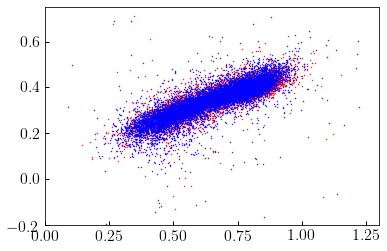

In [7]:
faint, bright = -19.75, -20.75
mask = um_mock['restframe_extincted_sdss_abs_magr'] < faint
mask *= (um_mock['restframe_extincted_sdss_abs_magr'] > bright)

sdss_mask = sdss['restframe_extincted_sdss_abs_magr'] < faint
sdss_mask *= (sdss['restframe_extincted_sdss_abs_magr'] > bright)
sdss_mask *= (sdss['z'] < 0.045)



fig, ax = plt.subplots(1, 1)
__=ax.scatter(um_mock['restframe_extincted_sdss_gr'][mask][::30], 
              um_mock['restframe_extincted_sdss_ri'][mask][::30], 
              s=0.2, color='red')

__=ax.scatter(sdss['restframe_extincted_sdss_gr'][sdss_mask], 
              sdss['restframe_extincted_sdss_ri'][sdss_mask], 
              s=0.2, color='blue')

xlim = ax.set_xlim(-0, 1.3)
ylim = ax.set_ylim(-0.2, 0.75)

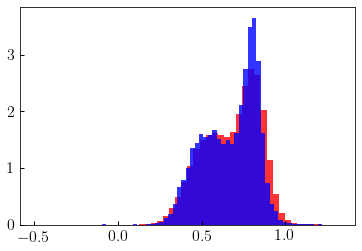

In [8]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(um_mock['restframe_extincted_sdss_gr'][mask], bins=50, normed=True, 
           alpha=0.8, color='red')
__=ax.hist(sdss['restframe_extincted_sdss_gr'][sdss_mask], bins=50, normed=True, 
           alpha=0.8, color='blue')

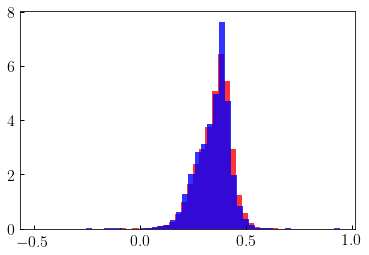

In [9]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(um_mock['restframe_extincted_sdss_ri'][mask], bins=50, normed=True, 
           alpha=0.8, color='red')
__=ax.hist(sdss['restframe_extincted_sdss_ri'][sdss_mask], bins=50, normed=True, 
           alpha=0.8, color='blue')

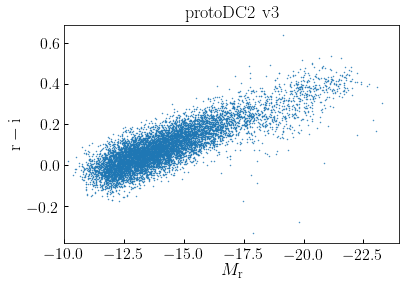

In [10]:
fig, ax = plt.subplots(1, 1)

__=ax.scatter(um_mock['restframe_extincted_sdss_abs_magr'][::1000], 
              um_mock['restframe_extincted_sdss_ri'][::1000], 
              s=0.2)


xlim = ax.set_xlim(-10, -24)
xlabel = ax.set_xlabel(r'$M_{\rm r}$')
ylabel = ax.set_ylabel(r'${\rm r-i}$')
title = ax.set_title(r'${\rm protoDC2\ v3}$')
figname = 'smooth_color_magnitude.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

#   Now check the clustering

In [11]:
from halotools.mock_observables import tpcf, wp, return_xyz_formatted_array

log_rbins = np.linspace(-1, 1.35, 20)
rbins = 10**log_rbins
log_rmids = 0.5*(log_rbins[:-1] + log_rbins[1:])
rmids = 10**log_rmids


In [12]:
sm_mask = um_mock['obs_sm'] > 10**10.75

npts = np.count_nonzero(sm_mask)
idx_magr_sorted = np.argsort(um_mock['restframe_extincted_sdss_abs_magr'])
magr_cut = um_mock['restframe_extincted_sdss_abs_magr'][idx_magr_sorted][npts]
magr_mask = um_mock['restframe_extincted_sdss_abs_magr'] < magr_cut

In [13]:
pos_sm = return_xyz_formatted_array(um_mock['x'], um_mock['y'], um_mock['z'], 
                                   mask=sm_mask)
pos_magr = return_xyz_formatted_array(um_mock['x'], um_mock['y'], um_mock['z'], 
                                   mask=magr_mask)

quenched_mask = sm_mask & (um_mock['obs_sfr']/um_mock['obs_sm'] < 10**-11)
pos_sm_quenched = return_xyz_formatted_array(um_mock['x'], um_mock['y'], um_mock['z'], 
                                   mask=quenched_mask)
active_mask = sm_mask & (um_mock['obs_sfr']/um_mock['obs_sm'] >= 10**-11)
pos_sm_active = return_xyz_formatted_array(um_mock['x'], um_mock['y'], um_mock['z'], 
                                   mask=active_mask)

num_quenched_sample = np.count_nonzero(quenched_mask)
idx_gr_sorted = np.argsort(um_mock['restframe_extincted_sdss_gr'][magr_mask])
gr_cut = um_mock['restframe_extincted_sdss_gr'][magr_mask][idx_gr_sorted][-num_quenched_sample]
red_mask = magr_mask & (um_mock['restframe_extincted_sdss_gr'] > gr_cut)
blue_mask = magr_mask & (um_mock['restframe_extincted_sdss_gr'] < gr_cut)

pos_magr_red = return_xyz_formatted_array(um_mock['x'], um_mock['y'], um_mock['z'], 
                                   mask=red_mask)
pos_magr_blue = return_xyz_formatted_array(um_mock['x'], um_mock['y'], um_mock['z'], 
                                   mask=blue_mask)


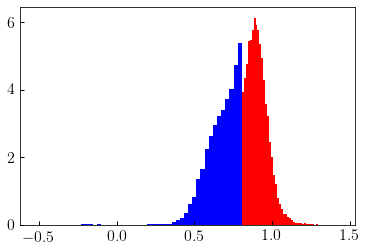

In [14]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(um_mock['restframe_extincted_sdss_gr'][red_mask], bins=50, normed=True, color='red')
__=ax.hist(um_mock['restframe_extincted_sdss_gr'][blue_mask], bins=50, normed=True, color='blue')

In [15]:
xi_sm = tpcf(pos_sm, rbins, period=250.)
xi_sm_active = tpcf(pos_sm_active, rbins, period=250.)
xi_sm_quenched = tpcf(pos_sm_quenched, rbins, period=250.)



In [16]:
xi_magr = tpcf(pos_magr, rbins, period=250.)
xi_magr_blue = tpcf(pos_magr_blue, rbins, period=250.)
xi_magr_red = tpcf(pos_magr_red, rbins, period=250.)

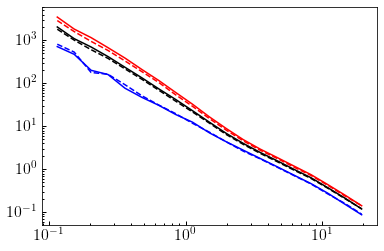

In [17]:
fig, ax = plt.subplots(1, 1)

__=ax.loglog()

__=ax.plot(rmids, xi_sm, color='k')
__=ax.plot(rmids, xi_magr, '--', color='k')

__=ax.plot(rmids, xi_sm_quenched, color='red')
__=ax.plot(rmids, xi_magr_red, '--', color='red')

__=ax.plot(rmids, xi_sm_active, color='blue')
__=ax.plot(rmids, xi_magr_blue, '--', color='blue')
